# Airbnb: cleaning fees

## Loading and preparing data

Data has been downloaded from: http://insideairbnb.com/get-the-data.html. The first step is to read the data.  

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
sns.set_style("white")

df = pd.read_csv("data/listings_amsterdam.csv", index_col="id", low_memory=False)

There are over 20 thousand listings in the Amsterdam data. Let start with having a look at the cleaning fees and the price per night. 

In [112]:
df[["price","cleaning_fee"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20025 entries, 2818 to 40655209
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         20025 non-null  object
 1   cleaning_fee  16421 non-null  object
dtypes: object(2)
memory usage: 469.3+ KB


It seems that price has no missing values, while the cleaning fee has over 3 thousand missing values. After checkig a few of the ads on the website, I concluded that the missing values can be interpreted as not charging a cleaning fee so they can be recoded to 0. Also, we need to get rid of the dollar sign (should be Euro actually) and convert the columns to floats. Also, I am creating a ratio between the two.

In [113]:
for var in ['price','cleaning_fee']:

    df[var] = df[var].replace({'\$':''}, regex=True)
    df[var] = df[var].replace({'\,':''}, regex=True).astype(float)

df['cleaning_fee'].fillna(0, inplace=True) 

df['cleaning_ratio'] = df.cleaning_fee / df.price


Lets see if the data have some outliers or other strange values.

In [114]:
df[['price','cleaning_fee','cleaning_ratio']].describe(percentiles=[.25,.5,.75,.9,.95,.99])

,price,cleaning_fee,cleaning_ratio
count,20025.000000,20025.000000,2.002500e+04
mean,163.251685,32.358652,inf
std,198.538156,27.821606,NaN
min,0.000000,0.000000,0.000000e+00
25%,99.000000,10.000000,8.823529e-02
50%,130.000000,30.000000,2.250000e-01
75%,185.000000,50.000000,3.333333e-01
90%,255.000000,60.000000,4.500000e-01
95%,345.000000,75.000000,5.333333e-01
99%,600.000000,120.000000,7.575758e-01


Seems like some of the listings have a price of 0 and some also have a quite extreme prices. Lets look more closely.

In [115]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='price').tail(8)

,price,cleaning_fee,cleaning_ratio
id,,,
19686192,5000.0,0.0,0.000000
29926643,5040.0,50.0,0.009921
33842636,7550.0,0.0,0.000000
258273,8000.0,15.0,0.001875
6655554,8915.0,500.0,0.056085
286500,9000.0,0.0,0.000000
290701,9000.0,0.0,0.000000
33730638,9000.0,0.0,0.000000


9000 per night is high, but not unusual so lets keep that data. The listings with a price of 0 are removed

In [116]:
df = df.loc[df.price != 0]

In [117]:
df[['price','cleaning_fee','cleaning_ratio']].sort_values(by='cleaning_fee').tail()

,price,cleaning_fee,cleaning_ratio
id,,,
5974980,118.0,480.0,4.067797
6655554,8915.0,500.0,0.056085
10328570,380.0,500.0,1.315789
2234543,600.0,500.0,0.833333
6149173,100.0,531.0,5.310000


Some cleaning fees look rather high and in some cases much higher than the price for one night. Most extreme is a 1000 Euro cleaning fee, but this is also for a listing with a price of 3900 per night so its realistic.

Next up some distribtional plots of the price and cleaning fee.

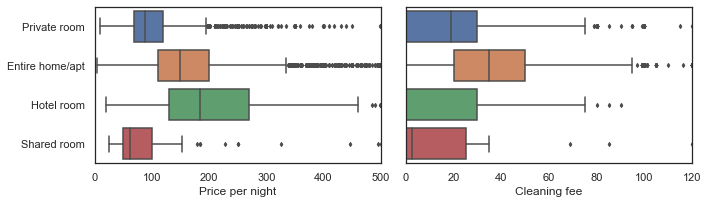

In [118]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,3))
sns.boxplot(x="price", y='room_type', data=df, ax=ax[0], fliersize=3)
sns.boxplot(x="cleaning_fee", y='room_type', data=df, ax=ax[1], fliersize=3)
ax[0].set_xlim(0,500)
ax[1].set_xlim(0,120)
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)
ax[0].set_xlabel('Price per night')
ax[1].set_xlabel('Cleaning fee')
plt.tight_layout()
plt.savefig("plots/fee_roomtype.png", dpi=300)
plt.show()


The plots above show that hotels charge the highest fees, while they also chage the lowest cleaning fees. In fact half of the hotels do not charge a cleaning fee. Cleaning fees are highest for entire homes with 75% of those homes charging between roughly 20 euros to 50 euros. Note that the x-axis has been cutoff, the distrution is heavily skewed.

## Saving by staying longer

Not lets calculate how much the average cost per night goes down if we stay longer. The cleaning fee is a fixed cost so that distributed over more nights the longer you stay. In addition many apartments offer discounts for a weekly or a monthly stay. For those that do not offer a weekly and a monthly price, we need to set this at 7 * the nightly price and 31/7 * the weekly price respectively. 

In [119]:
for var in ['weekly_price','monthly_price']:

    df[var] = df[var].replace({'\$':''}, regex=True)
    df[var] = df[var].replace({'\,':''}, regex=True).astype(float)
      
df['weekly_price'].fillna(df.price*7, inplace=True)
df['monthly_price'].fillna(df.weekly_price*(31/7), inplace=True)


Then we can calculate the average price regardless of the duration of the stay, the discount and the cleaning costs.

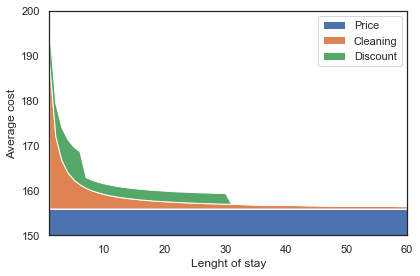

In [120]:
mean_cost = dict({'Days': [],'Price': [], 'Discount': [], 'Cleaning': []})

for j in range(1,61):

    mean_cost['Days'].append(j)
    mean_cost['Price'].append(np.mean(df.monthly_price) / 31)
    mean_cost['Cleaning'].append(np.mean(df.cleaning_fee) / j)

    if j<7:
        mean_cost['Discount'].append(np.mean(df.price) - np.mean(df.monthly_price) / 31)      
    elif j>=7 and j<=30:
        mean_cost['Discount'].append(np.mean(df.weekly_price) / 7 - np.mean(df.monthly_price) / 31)
    else:
        mean_cost['Discount'].append(0)
    
mean_cost = pd.DataFrame(mean_cost)

x=mean_cost['Days']
y=[ list(mean_cost['Price']), list(mean_cost['Cleaning']), list(mean_cost['Discount']) ]
 
plt.stackplot(x,y, labels=['Price',"Cleaning",'Discount'])
plt.legend(loc='upper right')
plt.ylim(150, 200)
plt.xlim(1, 60)
plt.ylabel('Average cost')
plt.xlabel('Lenght of stay')
plt.tight_layout()
plt.savefig("plots/staying_longer.png", dpi=300)
plt.show()

When just staying for one night you pay 156 euros plus the average cleaning fee of 32 euros and you miss out on over 7 euro in discounts for longer stays. This adds up to 196 euros per week. This drops rapidly the longer you stay as the cleaning fee can be distributed over a larger number of nights. The first discount hits in after a week and the averge costs drop to 163 euros. After 30 days there are no more discounts and the cleaning fee becomes negligible. As far as I can tell, Airbnb does not have a policy for (charging for) cleaning more than once in case of a long term stay.


## Who charges more for cleaning? 

What explains the level of the cleaning fee? Do more expensive places to stay come with higher cleaning fees? The plots below seem to suggest this is the case, though there is still a considerable amount of variation. 

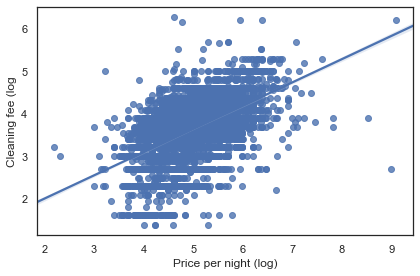

In [121]:
df['logprice'] = np.log(df.price)
df['logclean'] = np.log(df.cleaning_fee[df.cleaning_fee > 0])

sns.regplot(x='logprice', y='logclean', data=df)
plt.xlabel('Price per night (log)')
plt.ylabel('Cleaning fee (log')
plt.tight_layout()
plt.show()

The plot above excludes those who do not charge a cleaning fee at all. The average price is roughly 10 euros higher for listings that do not charge a cleaning fee. This may be because they absorb the cleaning costs into the price.

In [122]:
df['no_fee'] = df.cleaning_fee==0
df['no_fee'] = df['no_fee'].replace(True, 'No cleaning fee') 
df['no_fee'] = df['no_fee'].replace(False, 'Cleaning fee').astype('str') 
df['no_fee'][df.cleaning_fee.isnull()] = np.nan
df.groupby("no_fee").price.mean()

no_fee
Cleaning fee       160.777242
No cleaning fee    171.399359
Name: price, dtype: float64

In order to analyse what explains how large the cleaning fee is we can run a regression. The variables below might have an effect on the cleaning fee that is charged. Price is included because perhaps more expensive listings have a higher 'cleaning  standard'. Other variables are about size of the property: bathrooms, beds. We can assume this will have a positive effect as there is more to clean. The minimum number of nights might also have an effect. Perhaps some listings discourage short stays with a higher cleaning fee while others have a lower cleaning fee but a higher number of minimumn nights. Finally, the number of listings that the host has might impact the cleaning fee as well, because of economies of scale. 

Checking for missing values: seems negligible but we will impute it anyway. 

In [123]:
X_vars = ['host_listings_count',"property_type","room_type","accommodates","bathrooms","beds","logprice","minimum_nights","neighbourhood_cleansed"]

categorical_features = df[X_vars].columns[df[X_vars].dtypes==object].tolist()
numerical_features = df[X_vars].columns[df[X_vars].dtypes!=object].tolist()

for x in X_vars:
    print(x," :",  round(df[x].isnull().sum() / df.shape[0], 3))


host_listings_count  : 0.008
property_type  : 0.0
room_type  : 0.0
accommodates  : 0.0
bathrooms  : 0.0
beds  : 0.002
logprice  : 0.0
minimum_nights  : 0.0
neighbourhood_cleansed  : 0.0


Check if we need to recode some categorical variables

In [124]:
df.property_type.value_counts()

Apartment                 15227
House                      1673
Townhouse                   677
Bed and breakfast           418
Loft                        378
Condominium                 360
Boat                        339
Houseboat                   323
Guest suite                 157
Aparthotel                  111
Serviced apartment           69
Guesthouse                   48
Boutique hotel               42
Villa                        38
Hotel                        36
Hostel                       32
Other                        31
Tiny house                   14
Cabin                        13
Cottage                      12
Farm stay                     5
Bungalow                      4
Camper/RV                     3
Barn                          2
Yurt                          2
Chalet                        2
Lighthouse                    1
Earth house                   1
Dome house                    1
Bus                           1
Tent                          1
Casa par

The property type has quite some categories that are very rare. Any category with less than 200 occurances will be recoded into 'other'.

In [125]:
small_cats = df.property_type.value_counts()
small_cats = small_cats[small_cats<200].index

df['property_type'] = df.property_type.replace({x:'Other' for x in small_cats})
df.property_type.value_counts()

Apartment            15227
House                 1673
Townhouse              677
Other                  629
Bed and breakfast      418
Loft                   378
Condominium            360
Boat                   339
Houseboat              323
Name: property_type, dtype: int64

In [126]:
df.neighbourhood_cleansed.value_counts()

De Baarsjes - Oud-West                    3391
De Pijp - Rivierenbuurt                   2477
Centrum-West                              2186
Centrum-Oost                              1744
Westerpark                                1471
Zuid                                      1407
Oud-Oost                                  1323
Bos en Lommer                             1151
Oostelijk Havengebied - Indische Buurt     972
Oud-Noord                                  609
Watergraafsmeer                            550
IJburg - Zeeburgereiland                   475
Slotervaart                                435
Noord-West                                 385
Noord-Oost                                 292
Buitenveldert - Zuidas                     260
Geuzenveld - Slotermeer                    240
De Aker - Nieuw Sloten                     159
Osdorp                                     144
Gaasperdam - Driemond                      133
Bijlmer-Centrum                            114
Bijlmer-Oost 

Neighbourhoods look quite ok. Lets move on to split the data into training and testing sets

In [127]:
df.room_type.value_counts()

Entire home/apt    15578
Private room        4060
Hotel room           328
Shared room           58
Name: room_type, dtype: int64

In [128]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import r2_score

X = df[X_vars]
y = df['cleaning_fee']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


First up is checking for outliers. We will do so on the training set and apply the cutoff points inferred from the training set on the testing set.

In [129]:
X_train_described = X_train[numerical_features].describe(percentiles=[0.1,.25,.5,.75,.9,.95,.99])
X_train_described


,host_listings_count,accommodates,bathrooms,beds,logprice,minimum_nights
count,15894.000000,16019.000000,16016.000000,15993.000000,16019.000000,16019.000000
mean,3.877375,2.868344,1.179539,1.787219,4.923562,3.401211
std,29.294717,1.308685,0.386106,1.409362,0.529994,14.063238
min,0.000000,1.000000,0.000000,0.000000,1.609438,1.000000
10%,1.000000,2.000000,1.000000,1.000000,4.317488,1.000000
25%,1.000000,2.000000,1.000000,1.000000,4.595120,2.000000
50%,1.000000,2.000000,1.000000,1.000000,4.890349,2.000000
75%,1.000000,4.000000,1.500000,2.000000,5.220356,3.000000
90%,3.000000,4.000000,1.500000,3.000000,5.521461,5.000000
95%,5.000000,4.000000,2.000000,4.000000,5.823341,7.000000


Some extreme values in here. Lets remove all higher than the 99th percentile. 

In [130]:
for x,y in [(X_train,y_train),(X_test,y_test)]:
    for i in numerical_features:
        value = X_train_described.loc['99%',i]
        to_drop = x[x[i]>=value].index
        x.drop(to_drop,inplace=True)
        y.drop(to_drop,inplace=True)

Some variables are objects and these need to be dummy coded. The floats and integers will be standardised. The code below sets up the pipeline to do so.

In [131]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


Setting up the linear regressor and fitting the model. Using 10 fold crossvalidation.

In [132]:
steps = [('preprocessor', preprocessor),
         ('reg', LinearRegression())]

pipeline_reg = Pipeline(steps)

params_reg = {}
grid_reg = GridSearchCV(estimator=pipeline_reg,
                       param_grid=params_reg,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

grid_reg.fit(X_train, y_train)

y_pred = grid_reg.predict(X_test)

r2 = r2_score(y_test,y_pred)

print('Mean CV R2 score: ', round(grid_reg.cv_results_['mean_test_score'][0],3 ))
print('R2 in test data: ', round(r2, 3) )


Mean CV R2 score:  0.176
R2 in test data:  0.156


The R2 is not great, but there are not a lot of features to predict with in the first place. It doesn't look like the R2 in the test data is the result of overfitting as it is the same in the folds. 

Just to be sure we estimate an elasticnet and we penalise using alpha and the L1 ratio. 

In [133]:
steps_enet = [('preprocessor', preprocessor),
              ('reg', ElasticNet())]

pipeline_enet = Pipeline(steps_enet)

parametersGrid = {"reg__alpha": [0.001,0.01, 0.1,0.5,0.9,1],
                  "reg__l1_ratio": np.arange(0.1, 1, 0.1)}

grid_enet = GridSearchCV(pipeline_enet, parametersGrid, scoring='r2', cv=10, n_jobs=-1)

grid_enet.fit(X_train, y_train)

y_pred = grid_enet.predict(X_test)

r2 = r2_score(y_test,y_pred)

print('Mean CV R2 score: ', round(grid_enet.cv_results_['mean_test_score'][0],3 ))
print('R2 in test data: ', round(r2, 3) )


Mean CV R2 score:  0.176
R2 in test data:  0.157


THe outcome is the same so we can stick with the linear regression model. Lets have a look at the coefficients.

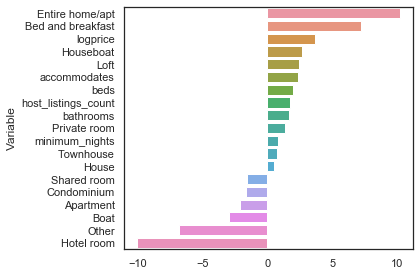

In [134]:
categorical_transformer.fit_transform(X_train[categorical_features])
catnames_array = categorical_transformer.named_steps['onehot'].get_feature_names().tolist()

catnames = []
for i in catnames_array:
    catnames.append(i)
names = numerical_features + catnames

coefficients = pd.DataFrame(dict({'Variable': names,
                                  'Coefficient': grid_reg.best_estimator_.named_steps['reg'].coef_})).sort_values('Coefficient', ascending=False)
    
coefficients = coefficients[coefficients.Variable.str.slice(stop=2)!="x2"]
coefficients['Variable'] = coefficients['Variable'].str.replace('x0_', '') 
coefficients['Variable'] = coefficients['Variable'].str.replace('x1_', '') 
sns.barplot(x='Coefficient', y='Variable',data=coefficients)
plt.xlabel(None)
plt.tight_layout()
plt.show()


Some takeaways
* The room type matters: having the entire home or apartment for yourself comes with a higher cleaning fee. Having a private room also comes with a higher cleaning fee, while staying in a shared room or hotel lowers the cleaning fee.
* The type of property matters: bed and breakfasts charge the largest cleaning fee and houseboats and lofts charge higher fees as well.
* The nightly rate is positively related to the cleaning fee.
* The size of the place matters: the more people it can accomodate, the larger the cleaning fee. Also the number of bedrooms and bathrooms matters.
* The number of listings the host has is positively related to the cleaning price. This is contrary to expectations as hosts do not seem to be able to benefit from economies of scale. 
* The number of minimum nights is positively related to the cleaning fee, contrary to expectations. Perhaps this means that hosts who are looking to avoid short stays to this both with cleaning fees as well as setting a minimum number of nights.

The plot shows us what has a positive and what has a negative effect on the cleaning fee, but it is not particularly useful because the coefficients of the numerical variables are standardised. Note: I excluded the neighbourhoods in the graph for presentational reasons. 

How much of the variance in cleaning fees is explained by each feature? Below we reestimate the model with statsmodels because statsmodels allows us to do ANOVA.


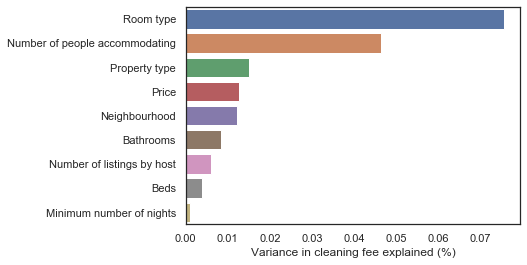

In [135]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline_lm = Pipeline([('preprocessor', preprocessor)])

X_train_preprocessed = pipeline_lm.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
X_train_preprocessed.columns = numerical_features + categorical_features

train = X_train_preprocessed
train['cleaning_fee'] = y_train.values
train[numerical_features] = train[numerical_features].apply(pd.to_numeric)

form = 'cleaning_fee ~ '
for x in X_vars:
    form += x + '+'
form = form[:-1]

lm = ols(form, data=train).fit()
anova = anova_lm(lm, typ=1) 
anova_plot_data = anova.loc[numerical_features + categorical_features,'sum_sq'] / anova.sum_sq.sum()
names = ['Number of listings by host', 'Number of people accommodating','Bathrooms','Beds','Price','Minimum number of nights','Property type','Room type','Neighbourhood']
anova_plot_data = pd.DataFrame(dict({'names': names, 'values': anova_plot_data})).sort_values(by='values', ascending=False)
sns.barplot(x="values",y="names",data=anova_plot_data)
plt.xlabel('Variance in cleaning fee explained (%)')
plt.ylabel(None)
plt.savefig("plots/variance.png", dpi=300)
plt.show()


This plot shows that of most of the variance in the cleaning fees can be explained by the room type, followed by the number of people the property can accomodate. Also property type and price explains a good deal of variance. Our overall R-squared is quite low, which means there is still a lot of variance in the cleaning fee that we cannot explain by any of the features included. Seems like hosts have other reasons to set their cleaning fee.

## Do higher cleaning fees lead to higher cleaning ratings?

Are the cleaning fees put to good use or are Airbnb hosts just sweeping up cash? The dataset contains a review score for cleanliness. More than half of the ratings are the maximum score.

In [136]:
print("Proportion of ratings with maximum score: ", round((df.review_scores_cleanliness==10).sum() / df.shape[0],2))

print("Proportion of missing ratings: ", round(df.review_scores_cleanliness.isnull().sum() / df.shape[0],2))

Proportion of ratings with maximum score:  0.54
Proportion of missing ratings:  0.13


Among those who score less than 10, 3 in 4 score a 9 and only a small group is below that. 

In [137]:
df.review_scores_cleanliness[df.review_scores_cleanliness!=10].describe()

count    6482.000000
mean        8.620488
std         0.873975
min         2.000000
25%         9.000000
50%         9.000000
75%         9.000000
max         9.000000
Name: review_scores_cleanliness, dtype: float64

It probably makes more sense to regard the rating variable as a binary one: maximum score or not. It seems that charging a cleaning fee is positively related to the score: among those who were charged a cleaning fee, 63% gives the maximum score for cleaniness, while this is 62% for those who do not charge a cleaning fee. The difference is not statistically significant though.

In [138]:
df['max_score'] = df.review_scores_cleanliness==10
df['max_score'] = df['max_score'].replace(True, '10') 
df['max_score'] = df['max_score'].replace(False, '<10').astype('str') 
df['max_score'][df.review_scores_cleanliness.isnull()] = np.nan

print(pd.crosstab(df['no_fee'], df['max_score'], normalize=0))

from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency( pd.crosstab(df['no_fee'], df['max_score']))

print('p-value of chi-squared test: ', round(p,2))

max_score              10       <10
no_fee                             
Cleaning fee     0.629135  0.370865
No cleaning fee  0.619921  0.380079
p-value of chi-squared test:  0.32


Looking at those who charge a fee, it seems a higher cleaning fee is related to a higher score on cleanliness. The difference in the fee is less than a euro, however. 

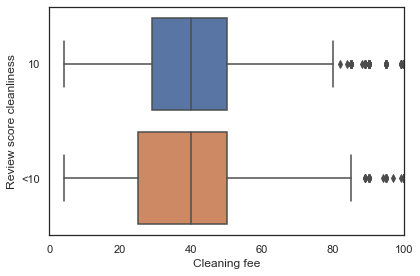

In [139]:
sns.boxplot(x='cleaning_fee',y="max_score", data=df[df.no_fee=='Cleaning fee'])
plt.xlim(0, 100)
plt.xlabel('Cleaning fee')
plt.ylabel('Review score cleanliness')
plt.tight_layout()
plt.savefig("plots/cleanliness.png", dpi=300)
plt.show()

In [140]:
df.groupby('max_score').cleaning_fee.describe()

,count,mean,std,min,25%,50%,75%,max
max_score,,,,,,,,
10,10908.0,33.155116,26.022808,0.0,15.0,33.0,50.0,500.0
<10,6482.0,32.631749,25.500090,0.0,15.0,30.0,50.0,500.0


The t-test for equality of means shows we cannot reject the null hypothesis that the cleaning fee is equal. In other words: there seems to be no effect of the level of the cleaning fee on the rating.

In [141]:
from scipy.stats import ttest_ind
ttest_ind(df.cleaning_fee[(df.max_score=='10') & (df.no_fee=='Cleaning fee')], df.cleaning_fee[(df.max_score=='<10') & (df.no_fee=='Cleaning fee')])


Ttest_indResult(statistic=0.8369865371753608, pvalue=0.4026145831713023)

## Conclusions

* The price you pay per night decreases the longer you stay. The cleaning fee is a fixed amount and is spread over more days the longer you stay. Also, you get discounts for booking longer than a week and longer than a month in some cases. You can save the most by booking a week. After that the gains are smaller.
* What explains the level of the cleaning fee? There is a considerable amount of variance in the cleaning price that cannot be explained. However, the more private and the larger the place, the higher the cleaning fee. In addition, more expensive places charge higher fees. Be aware of these hidden costs when booking through Airbnb.
* Those who charge a cleaning fee do not have a higher cleanliness rating than those who do not. Also, a higher cleaning fee is not related to a higher cleanliness score. 


